In [1]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    XLMRobertaForSequenceClassification,
    TrainerCallback
    )
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from datasets import Dataset, DatasetDict
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report, confusion_matrix



c:\Users\MSI\.conda\envs\Atelier_ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_df = pd.read_csv("C:\\Users\\MSI\\Desktop\\customer_review_analysis\\data\\cleaned\\finetuning-splits\\test_set.csv")


In [3]:


model_path1 = "C:\\Users\\MSI\\Desktop\\customer_review_analysis\\finetuning_models\\my_sentiment_model"
model_path_2 = "C:\\Users\\MSI\\Desktop\\customer_review_analysis\\finetuning_models\\my_sentiment_model_without_augmentation"
model_path_3 = "C:\\Users\\MSI\\Desktop\\customer_review_analysis\\finetuning_models\\my_sentiment_model_data_augmentation"
model_path_4 = "C:\\Users\\MSI\\Desktop\\customer_review_analysis\\finetuning_models\\my_sentiment_model_data_augmentation_not_cleaned"
# Modèle 1
tokenizer1 = AutoTokenizer.from_pretrained(model_path1)
model1 = AutoModelForSequenceClassification.from_pretrained(model_path1)
model1.eval()

# Modèle 2
tokenizer2 = AutoTokenizer.from_pretrained(model_path_2)
model2 = AutoModelForSequenceClassification.from_pretrained(model_path_2)
model2.eval()

# Modéle 3
tokenizer3 = AutoTokenizer.from_pretrained("xlm-roberta-base")
model3 = XLMRobertaForSequenceClassification.from_pretrained(model_path_3)
model3.eval()
# Modéle 4
tokenizer4 = AutoTokenizer.from_pretrained("xlm-roberta-base")
model4 = XLMRobertaForSequenceClassification.from_pretrained(model_path_4)  
model4.eval()


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [4]:
def evaluate_model(model, tokenizer, test_texts, true_labels):
    predictions = []

    with torch.no_grad():
        for text in test_texts:
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding=True
            )
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            predictions.append(pred)

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, output_dict=True)
    cm = confusion_matrix(true_labels, predictions)

    return accuracy, report, cm, predictions

In [6]:
test_texts = test_df["text"].tolist()
true_labels = test_df["label"].tolist()

acc1, report1, cm1, preds1 = evaluate_model(model1, tokenizer1, test_texts, true_labels)
acc2, report2, cm2, preds2 = evaluate_model(model2, tokenizer2, test_texts, true_labels)
acc3, report3, cm3, preds3 = evaluate_model(model3, tokenizer3, test_texts, true_labels)
acc4, report4, cm4, preds4 = evaluate_model(model4, tokenizer4, test_texts, true_labels)


In [7]:
def build_comparison_table(report1, report2, report3, report4):
    df1 = pd.DataFrame(report1).transpose()
    df2 = pd.DataFrame(report2).transpose()
    df3 = pd.DataFrame(report3).transpose()
    df4 = pd.DataFrame(report4).transpose()

    comparison = pd.DataFrame({
        "Model 1 - Precision": df1["precision"],
        "Model 2 - Precision": df2["precision"],
        "Model 3 - Precision": df3["precision"],
        "Model 4 - Precision": df4["precision"],
        "Model 1 - Recall": df1["recall"],
        "Model 2 - Recall": df2["recall"],  
        "Model 3 - Recall": df3["recall"],
        "Model 4 - Recall": df4["recall"],
        "Model 1 - F1": df1["f1-score"],
        "Model 2 - F1": df2["f1-score"],
        "Model 3 - F1": df3["f1-score"],
        "Model 4 - F1": df4["f1-score"],
        
    })

    return comparison

comparison_df = build_comparison_table(report1, report2, report3, report4)
comparison_df

,Model 1 - Precision,Model 2 - Precision,Model 3 - Precision,Model 4 - Precision,Model 1 - Recall,Model 2 - Recall,Model 3 - Recall,Model 4 - Recall,Model 1 - F1,Model 2 - F1,Model 3 - F1,Model 4 - F1
0,0.913043,0.826087,0.904762,0.913043,0.875000,0.791667,0.791667,0.875000,0.893617,0.808511,0.844444,0.893617
1,0.333333,1.000000,0.285714,0.285714,0.200000,0.100000,0.400000,0.200000,0.250000,0.181818,0.333333,0.235294
2,0.875000,0.847059,0.932432,0.873418,0.933333,0.960000,0.920000,0.920000,0.903226,0.900000,0.926174,0.896104
accuracy,0.853211,0.844037,0.844037,0.844037,0.853211,0.844037,0.844037,0.844037,0.853211,0.844037,0.844037,0.844037
macro avg,0.707126,0.891049,0.707636,0.690725,0.669444,0.617222,0.703889,0.665000,0.682281,0.630110,0.701317,0.675005
weighted avg,0.833682,0.856472,0.867008,0.828225,0.853211,0.844037,0.844037,0.844037,0.841181,0.813967,0.853790,0.834932


In [8]:
comparison_global = pd.DataFrame({
    "Modèle": ["Modèle 1", "Modèle 2","Modèle 3","Modèle 4"],
    "Accuracy": [acc1, acc2, acc3, acc4],
    "F1-weighted": [
        report1["weighted avg"]["f1-score"],
        report2["weighted avg"]["f1-score"],
        report3["weighted avg"]["f1-score"],
        report4["weighted avg"]["f1-score"]
    ],
    "F1-macro": [
        report1["macro avg"]["f1-score"],
        report2["macro avg"]["f1-score"],
        report3["macro avg"]["f1-score"],
        report4["macro avg"]["f1-score"]
    ]
})

comparison_global


,Modèle,Accuracy,F1-weighted,F1-macro
0,Modèle 1,0.853211,0.841181,0.682281
1,Modèle 2,0.844037,0.813967,0.630110
2,Modèle 3,0.844037,0.853790,0.701317
3,Modèle 4,0.844037,0.834932,0.675005


## Model Performance Analysis

The results show that the model trained on a balanced dataset using data augmentation (Model 3) achieves the best overall performance in terms of **F1-macro score** and **minority class detection**. This confirms the effectiveness of data augmentation in reducing the bias caused by the initial class imbalance.

The **F1-macro score** is the unweighted average of the F1-scores computed independently for each class. It gives the same importance to all classes, regardless of their frequency, making it a particularly suitable metric for evaluating models trained on imbalanced datasets.


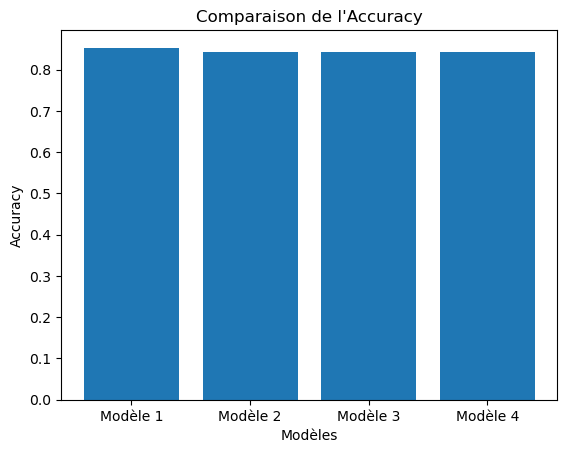

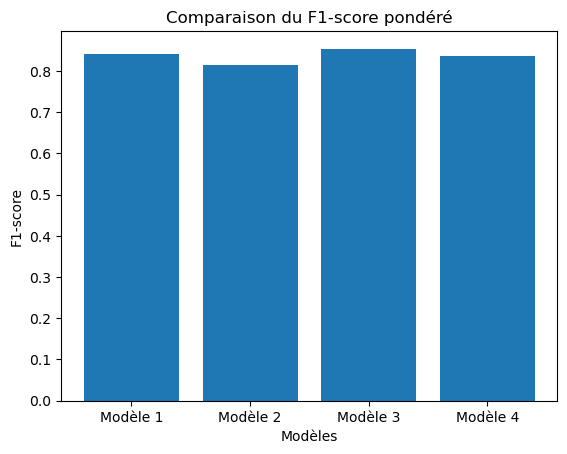

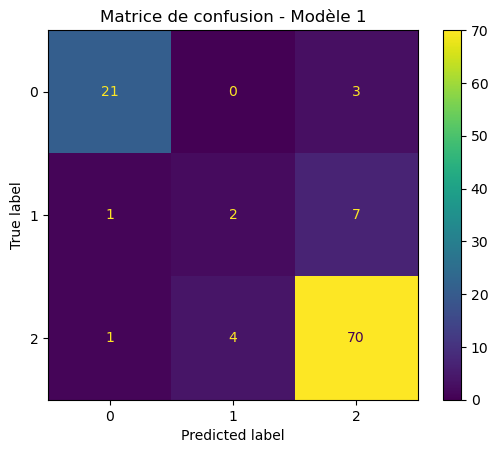

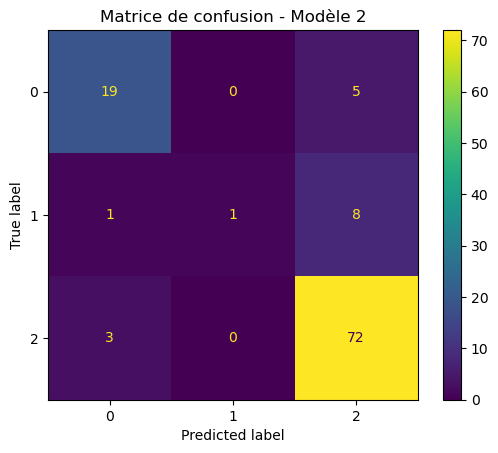

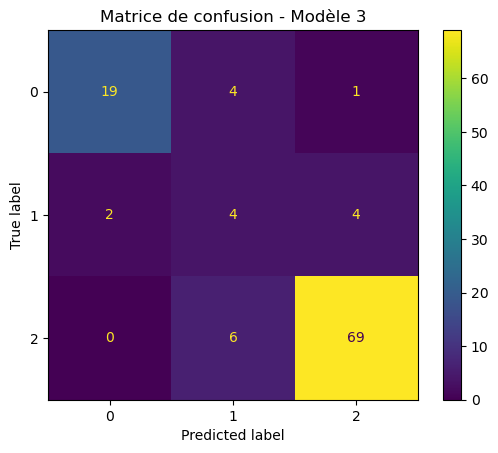

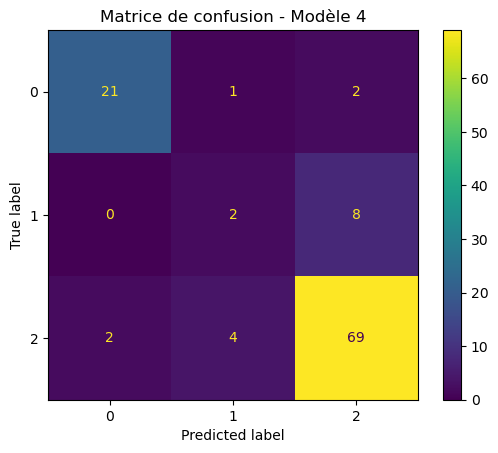

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ===== 1) Graphique ACCURACY =====
models = ["Modèle 1", "Modèle 2", "Modèle 3", "Modèle 4"]
accuracies = [acc1, acc2, acc3, acc4]

plt.figure()
plt.bar(models, accuracies)
plt.title("Comparaison de l'Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Modèles")
plt.show()


# ===== 2) Graphique F1-score (weighted) =====
f1_scores = [
    report1["weighted avg"]["f1-score"],
    report2["weighted avg"]["f1-score"],
    report3["weighted avg"]["f1-score"],
    report4["weighted avg"]["f1-score"]
]

plt.figure()
plt.bar(models, f1_scores)
plt.title("Comparaison du F1-score pondéré")
plt.ylabel("F1-score")
plt.xlabel("Modèles")
plt.show()


# ===== 3) Matrice de confusion du Modèle 1 =====
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot()
plt.title("Matrice de confusion - Modèle 1")
plt.show()


# ===== 4) Matrice de confusion du Modèle 2 =====
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot()
plt.title("Matrice de confusion - Modèle 2")
plt.show()
# ===== 5) Matrice de confusion du Modèle 3 =====
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp3.plot()
plt.title("Matrice de confusion - Modèle 3")
plt.show()

# ===== 6) Matrice de confusion du Modèle 4 =====
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4)
disp4.plot()
plt.title("Matrice de confusion - Modèle 4")
plt.show()


In [10]:
f1_by_class = pd.DataFrame({
    "Classe": ["Négatif (0)", "Neutre (1)", "Positif (2)"],

    "Modèle 1": [
        report1["0"]["f1-score"],
        report1["1"]["f1-score"],
        report1["2"]["f1-score"]
    ],

    "Modèle 2": [
        report2["0"]["f1-score"],
        report2["1"]["f1-score"],
        report2["2"]["f1-score"]
    ],

    "Modèle 3": [
        report3["0"]["f1-score"],
        report3["1"]["f1-score"],
        report3["2"]["f1-score"]
    ],

    "Modèle 4": [
        report4["0"]["f1-score"],
        report4["1"]["f1-score"],
        report4["2"]["f1-score"]
    ],
})

f1_by_class


,Classe,Modèle 1,Modèle 2,Modèle 3,Modèle 4
0,Négatif (0),0.893617,0.808511,0.844444,0.893617
1,Neutre (1),0.250000,0.181818,0.333333,0.235294
2,Positif (2),0.903226,0.900000,0.926174,0.896104


In [11]:
test_df["label"].value_counts().sort_index()


label
0    24
1    10
2    75
Name: count, dtype: int64

In [12]:
pd.Series(preds1).value_counts().sort_index()


0    23
1     6
2    80
Name: count, dtype: int64